### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
beta = pd.read_feather("beta/betas_condensed.fth")
spread_dom = pd.read_csv("all_times.csv").drop(["beta"],axis=1)

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    global beta
    global spread_dom
    
    df = pd.merge(df, beta, how="left")
    df = pd.merge(df, spread_dom, how="left")
    return df
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def beta_encoding(df):
    beta1 = np.repeat(np.nan, df.shape[0])
    beta2 = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        bmean1 = df.iloc[idx_1].groupby('stock_id')['beta'].mean()
        bmean2 = df.iloc[idx_1].groupby('stock_id')['beta2'].mean()
        beta1[idx_2] = df['stock_id'].iloc[idx_2].map(bmean1)
        beta2[idx_2] = df['stock_id'].iloc[idx_2].map(bmean2)
        
    df['encode_mean_beta'] = beta1
    df['encode_mean_beta2'] = beta2
    
    return df.drop(['beta','beta2'], axis=1)

def target_encoding(df):
    tenc = np.repeat(np.nan, df.shape[0])
    senc = np.repeat(np.nan, df.shape[0])
    denc = np.repeat(np.nan, df.shape[0])
    tencs = np.repeat(np.nan, df.shape[0])
    sencs = np.repeat(np.nan, df.shape[0])
    dencs = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        smean = df.iloc[idx_1].groupby('stock_id')['spread'].mean()
        dmean = df.iloc[idx_1].groupby('stock_id')['dom'].mean()
        tmeans = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].std()
        smeans = df.iloc[idx_1].groupby('stock_id')['spread'].std()
        dmeans = df.iloc[idx_1].groupby('stock_id')['dom'].std()
        tenc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
        senc[idx_2] = df['stock_id'].iloc[idx_2].map(smean)
        denc[idx_2] = df['stock_id'].iloc[idx_2].map(dmean)
        tencs[idx_2] = df['stock_id'].iloc[idx_2].map(tmeans)
        sencs[idx_2] = df['stock_id'].iloc[idx_2].map(smeans)
        dencs[idx_2] = df['stock_id'].iloc[idx_2].map(dmeans)
    df['target_mean_enc'] = tenc
    df['spread_mean_enc'] = senc
    df['dom_mean_enc'] = denc
    df['target_std_enc'] = tencs
    df['spread_std_enc'] = sencs
    df['dom_std_enc'] = dencs
    
    return df.drop(['dom','spread'], axis=1)

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_diff']
    aspread = df['ask_diff']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"extend_two/stock_{stock_id}.fth"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    df = pd.concat(df, ignore_index = True)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    df = import_beta(df)
    df = target_encoding(df)
    df = beta_encoding(df)
    return df

def generate_features(file_path):
    df = pd.read_feather(file_path)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)   
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'wap_diff':[np.std, np.max],#, mad, np.max, np.sum],
        'price_diff':[np.max, np.std], #np.max, np.sum],#, mad, np.max, np.sum],
        'price_diff2':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'ask_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std, np.max],#, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.max],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        'slope':[np.mean, np.max, np.std],#, mad, np.max, np.sum],
        'dispersion':[np.mean, np.max],#, mad, np.max, np.sum],
        'price_impact':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'turn_over':[np.mean, np.std, np.max]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=900  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[900, 600, 300, 150],  # features generated for each second interval (different widths)
        overlap=1,
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

## Process Features for All Stocks

In [4]:
all_stocks = process_stocks(beta.stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.9min finished


,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.523405,0.137002,194.494943,0.153934,0.004921,0.000164,3.455208e-09,-9.753985e-07,...,0.737558,0.778640,0.003128,0.001115,397.293407,0.002455,0.001078,105.806123,0.630854,0.635461
1,16,0.001295,209.519609,0.379075,209.558521,0.383354,0.005600,0.000187,1.099042e-07,-2.355713e-06,...,4.284855,1.519335,0.003132,0.001117,397.224904,0.002459,0.001080,106.088941,0.626157,0.631110
2,72,0.006357,191.553810,0.364277,191.534358,0.383770,0.007720,0.000257,1.346483e-07,-3.936685e-06,...,0.138981,-0.628995,0.003121,0.001115,397.266751,0.002431,0.001076,106.022659,0.630189,0.634104
3,146,0.002993,192.765232,0.641515,192.735618,0.657042,0.011335,0.000378,1.127322e-06,-6.358684e-06,...,1.343053,1.346464,0.003125,0.001112,397.208483,0.002458,0.001077,106.133936,0.635595,0.639401
4,169,0.001498,192.219228,5.420681,192.208617,5.426199,0.060467,0.002017,3.980222e-03,6.443939e-05,...,-3.478377,-4.443506,0.003123,0.001115,397.382076,0.002453,0.001079,105.890412,0.624722,0.629870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213355,32748,0.003057,191.609684,1.258293,191.604521,1.254466,0.013254,0.000442,6.904742e-06,2.088613e-05,...,3.532491,4.055885,0.004102,0.001183,384.992090,0.002739,0.000883,100.109065,1.028023,1.016579
213356,32750,0.001827,244.526554,1.607117,244.538262,1.625978,0.012686,0.000423,5.504136e-06,-1.615979e-05,...,-4.369014,-3.258371,0.004120,0.001186,384.746101,0.002757,0.000886,100.470191,1.034717,1.025261
213357,32751,0.002899,308.076728,1.006311,308.107535,0.989751,0.007706,0.000257,5.021137e-07,-9.098024e-06,...,3.484390,1.049953,0.004106,0.001184,384.614148,0.002750,0.000885,100.301940,1.026255,1.018215
213358,32758,0.002792,199.448299,2.496420,199.399570,2.520482,0.026106,0.000871,1.302272e-04,2.968647e-05,...,-0.570789,-0.046489,0.004093,0.001177,384.339698,0.002716,0.000864,99.786474,1.025761,1.017687


In [6]:
all_stocks = all_stocks.reset_index(drop=True)
all_stocks.memory_usage()

Index                             128
time_id                       1706880
target_realized_volatility    1706880
wap_mean_900                  1706880
wap_std_900                   1706880
                               ...   
target_std_enc                1706880
spread_std_enc                1706880
dom_std_enc                   1706880
encode_mean_beta              1706880
encode_mean_beta2             1706880
Length: 238, dtype: int64

In [7]:
del beta
del spread_dom  # don't need in memory anymore

### Rows with NaN are timeIDs that do not have extend2 chains
We will remove these rows as well

In [8]:
all_stocks[all_stocks.isna().any(axis=1)]

,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
53361,438,0.0,6.462332,0.003719,6.467540,0.007076,0.002157,0.000088,9.605405e-10,-0.000003,...,0.0,0.0,0.002775,0.001204,164049.748185,0.002010,0.000326,115826.958906,0.020454,0.022012
53387,908,0.0,10.666047,0.029419,10.663500,0.030313,0.004513,0.000184,5.327055e-09,-0.000013,...,0.0,0.0,0.002778,0.001203,163833.912906,0.002010,0.000327,115821.772486,0.020616,0.022170
53389,985,0.0,6.203054,0.015438,6.206899,0.016563,0.007450,0.000304,3.513963e-08,0.000016,...,0.0,0.0,0.002779,0.001203,164074.485361,0.002010,0.000327,115873.061855,0.020539,0.022118
53394,1070,0.0,11.508261,0.007490,11.509986,0.014674,0.001551,0.000063,9.254404e-11,0.000004,...,0.0,0.0,0.002776,0.001203,163870.659798,0.002000,0.000327,115927.824776,0.020663,0.022217
53441,1826,0.0,6.867056,0.006250,6.869535,0.006810,0.002436,0.000100,2.935553e-09,0.000006,...,0.0,0.0,0.002781,0.001202,163516.308659,0.002005,0.000327,115640.341970,0.020643,0.022271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55158,31214,0.0,12.030084,0.004779,12.024147,0.002944,0.001075,0.000044,2.038750e-11,0.000002,...,0.0,0.0,0.002779,0.001203,164074.485361,0.002010,0.000327,115873.061855,0.020539,0.022118
55181,31554,0.0,6.351642,0.004905,6.357288,0.008465,0.001262,0.000052,2.574201e-10,-0.000003,...,0.0,0.0,0.002772,0.001202,164055.232698,0.002000,0.000327,115767.306075,0.020678,0.022282
55183,31587,0.0,6.756079,0.054878,6.755031,0.053722,0.015810,0.000646,2.561381e-07,0.000028,...,0.0,0.0,0.002778,0.001203,163873.427854,0.002008,0.000327,115652.146975,0.020552,0.022013
55206,32174,0.0,6.972698,0.009453,6.971738,0.011020,0.003902,0.000159,4.880479e-09,0.000005,...,0.0,0.0,0.002778,0.001203,164152.092332,0.002012,0.000327,115977.389041,0.020646,0.022211


In [9]:
all_stocks = all_stocks[~(all_stocks.isna().any(axis=1))]

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [10]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

1

In [11]:
nozeros = all_stocks[all_stocks['target_realized_volatility'] != 0].reset_index(drop=True)
nozeros

,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.523405,0.137002,194.494943,0.153934,0.004921,0.000164,3.455208e-09,-9.753985e-07,...,0.737558,0.778640,0.003128,0.001115,397.293407,0.002455,0.001078,105.806123,0.630854,0.635461
1,16,0.001295,209.519609,0.379075,209.558521,0.383354,0.005600,0.000187,1.099042e-07,-2.355713e-06,...,4.284855,1.519335,0.003132,0.001117,397.224904,0.002459,0.001080,106.088941,0.626157,0.631110
2,72,0.006357,191.553810,0.364277,191.534358,0.383770,0.007720,0.000257,1.346483e-07,-3.936685e-06,...,0.138981,-0.628995,0.003121,0.001115,397.266751,0.002431,0.001076,106.022659,0.630189,0.634104
3,146,0.002993,192.765232,0.641515,192.735618,0.657042,0.011335,0.000378,1.127322e-06,-6.358684e-06,...,1.343053,1.346464,0.003125,0.001112,397.208483,0.002458,0.001077,106.133936,0.635595,0.639401
4,169,0.001498,192.219228,5.420681,192.208617,5.426199,0.060467,0.002017,3.980222e-03,6.443939e-05,...,-3.478377,-4.443506,0.003123,0.001115,397.382076,0.002453,0.001079,105.890412,0.624722,0.629870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213292,32748,0.003057,191.609684,1.258293,191.604521,1.254466,0.013254,0.000442,6.904742e-06,2.088613e-05,...,3.532491,4.055885,0.004102,0.001183,384.992090,0.002739,0.000883,100.109065,1.028023,1.016579
213293,32750,0.001827,244.526554,1.607117,244.538262,1.625978,0.012686,0.000423,5.504136e-06,-1.615979e-05,...,-4.369014,-3.258371,0.004120,0.001186,384.746101,0.002757,0.000886,100.470191,1.034717,1.025261
213294,32751,0.002899,308.076728,1.006311,308.107535,0.989751,0.007706,0.000257,5.021137e-07,-9.098024e-06,...,3.484390,1.049953,0.004106,0.001184,384.614148,0.002750,0.000885,100.301940,1.026255,1.018215
213295,32758,0.002792,199.448299,2.496420,199.399570,2.520482,0.026106,0.000871,1.302272e-04,2.968647e-05,...,-0.570789,-0.046489,0.004093,0.001177,384.339698,0.002716,0.000864,99.786474,1.025761,1.017687


In [67]:
nozeros[nozeros.isna().any(axis=1)]

,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2


### Defining X for LightGBM

* should scale features if regularization?

In [ ]:
all_stocks_X = nozeros.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
all_stocks_X

### Defining y for LightGBM

In [ ]:
all_stocks_y = nozeros[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

In [ ]:
all_stocks_y

Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [ ]:
EPSILON = 1e-10 #1e-10 set epsilon to zero as removed zero row for realized volatility

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred, n=4):
    return  round(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))), n)

def feval_RMSPE(preds, lgbm_train, n=4):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), n), False

### Optimizing Parameters

In [ ]:
#!pip install optuna
#https://github.com/optuna/optuna/issues/3203

In [ ]:
# import optuna
# import warnings

# optuna.logging.set_verbosity(optuna.logging.ERROR)
# warnings.filterwarnings('ignore')

# kfold = KFold(5, random_state=42, shuffle=True)
# params_fixed = {'metric': 'rmse',
#                 'n_jobs': -1,
#                 "force_col_wise": True,
#                 "extra_trees": True,
#                 'seed': 42}  # i will slow down learning rate for real run
    
# def objective(trial, cv=kfold):
    
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate",0.00999,0.1),
#         "feature_fraction": trial.suggest_float("feature_fraction",0.5,1), 
#         "bagging_fraction": trial.suggest_float("bagging_fraction",0.5,1),
#         "lambda_l1": trial.suggest_float("lambda_l1",0.4,1.6),
#         "lambda_l2": trial.suggest_float("lambda_l2",0.4,1.6),
#         'num_leaves': trial.suggest_int('num_leaves', 200, 1000),
#         'min_data_in_leaf':trial.suggest_int('min_data_in_leaf',20,200),
#         'bagging_freq': trial.suggest_int('bagging_freq',1,10)}
    
#     params.update(params_fixed)
#     pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse", valid_name='valid_1')
#     rmspes = []
    
#     for kfold, (train_idx, valid_idx) in enumerate(cv.split(all_stocks_X, all_stocks_y)):
     
#         X_train = all_stocks_X.iloc[train_idx].reset_index(drop=True)     
#         X_valid = all_stocks_X.iloc[valid_idx].reset_index(drop=True)
   
#         y_train = all_stocks_y.iloc[train_idx].reset_index(drop=True)['target_realized_volatility']
#         y_valid = all_stocks_y.iloc[valid_idx].reset_index(drop=True)['target_realized_volatility']
            
#         lgbm_train = lgbm.Dataset(X_train,y_train,weight=1/(np.square(y_train.values)+EPSILON))
#         lgbm_valid = lgbm.Dataset(
#             X_valid,y_valid,reference=lgbm_train,weight=1/(np.square(y_valid.values)+EPSILON))

#         model = lgbm.train(
#             params=params,
#             train_set=lgbm_train,
#             valid_sets=[lgbm_train, lgbm_valid], 
#             num_boost_round=10000,
#             feval=feval_RMSPE,
#             callbacks=[pruning_callback, lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
#         )
        
#         y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
#         RMSPE = rmspe(
#             y_true=(y_valid.values.flatten()), 
#             y_pred=(y_pred), n=4
#         )
#         rmspes.append(RMSPE)
        
#     return np.mean(rmspes)

# search = optuna.create_study(
#     direction='minimize', 
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=30)
# )
# search.optimize(objective, timeout=1800)
    
# print('Number of trials:', len(search.trials))
# print('Best parameters:', search.best_trial.params)

### Nested 5-Fold Cross-Validation

In [119]:
%%time

EPSILON = 0
test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]}

)
all_models = []
all_models600 = []
split_importance = []
split_importance600 = []
gain_importance = []
gain_importance600 = []
train_scores = []
train_scores600 = []
inner_k = 5
outer_k = 5

params =  {
    'boosting_type': 'goss',
    'learning_rate': 0.01,
    'metric': 'rmse',
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8,
    'lambda_l1': 1.2,
    'lambda_l2': 1.2,
    'n_jobs': -1,
    'force_col_wise': True,
    'extra_trees': True,
    'seed': 42
}

#params.update(search.best_trial.params)

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_train600 = X_outer_train.copy().loc[:,~(X_outer_train.columns.str.endswith(('_900','_600')))]   
    
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    X_outer_test600 = X_outer_test.copy().loc[:,~(X_outer_test.columns.str.endswith(('_900','_600')))]                
    
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    target600 = np.zeros(len(y_outer_test))
    
    inner_scores = 0.0
    inner_scores600 = 0.0
    
    models = []
    models600 = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_train600 = X_inner_train.copy().loc[:,~(X_inner_train.columns.str.endswith(('_900','_600')))]                
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        X_inner_valid600 = X_inner_valid.copy().loc[:,~(X_inner_valid.columns.str.endswith(('_900','_600')))]

        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
            
        lgbm_train = lgbm.Dataset(X_inner_train,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_train600 = lgbm.Dataset(X_inner_train600,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_valid = lgbm.Dataset(
            X_inner_valid,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        lgbm_valid600 = lgbm.Dataset(
            X_inner_valid600,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        
        print("Training Extended model...")
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        print("Training Simple model...")
        # model training
        model600 = lgbm.train(
            params=params,
            train_set=lgbm_train600,
            valid_sets=[lgbm_train600, lgbm_valid600],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred), n=4
        )
        y_inner_pred600 = model600.predict(X_inner_valid600, num_iteration=model600.best_iteration)
        RMSPE600 = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred600), n=4
        )
        
        print("\t"+"*" * 103)
        print(f'\tInner Validation RMSPE: {RMSPE}\t|\tInner Validation RMSPE-600: {RMSPE600}')
        print("\t"+"*" * 103)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        inner_scores600 += RMSPE600 / inner_k
        models.append(model)
        models600.append(model600)

        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        features600 = list(X_inner_train600.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
        gain_importance600.append(compute_importance(model600, features600, typ='gain'))
        split_importance600.append(compute_importance(model600, features600, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    all_models600.append(models600)
    train_scores600.append(inner_scores600)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test,num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
    # out of fold test set 600
    
    for model in all_models600[outer_fold]:
        y_outer_pred = model.predict(X_outer_test600,num_iteration=model.best_iteration)
        target600 += y_outer_pred / len(all_models600[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    y_outer_test = y_outer_test.assign(predicted_volatility600 = target600)
    
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

Training Extended model...
[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 136509, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001202
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000520829	training's RMSPE: 0.3468	valid_1's rmse: 0.000527197	valid_1's RMSPE: 0.346
[200]	training's rmse: 0.000421522	training's RMSPE: 0.2807	valid_1's rmse: 0.000437282	valid_1's RMSPE: 0.287
[300]	training's rmse: 0.000396109	training's RMSPE: 0.2638	valid_1's rmse: 0.000416266	valid_1's RMSPE: 0.2732
[400]	training's rmse: 0.000386451	train

Early stopping, best iteration is:
[2316]	training's rmse: 0.000343294	training's RMSPE: 0.229	valid_1's rmse: 0.000385823	valid_1's RMSPE: 0.2516
Training Simple model...
[LightGBM] [Info] Total Bins 31222
[LightGBM] [Info] Number of data points in the train set: 136509, number of used features: 123
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001199
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000522762	training's RMSPE: 0.3487	valid_1's rmse: 0.000527556	valid_1's RMSPE: 0.3441
[200]	training's rmse: 0.000423952	training's RMSPE: 0.2828	valid_1's rmse: 0.000437803	valid_1's RMSPE: 0.2856
[300]	training's rmse: 0.000399036	training's RMSPE: 0.2661	valid_1's rmse: 0.000417025	valid_1's RMSPE: 0.272
[400]	training's rmse: 0.000389555	training's RMSPE: 0.2598	valid_1's rmse: 0.000409806	valid_1's RMSPE: 0.2673
[500]	training's rmse: 0.000383713	training's RMSPE: 0.2559	valid_1's rmse: 0.000405856	valid_1's RMSPE: 0.

[1800]	training's rmse: 0.000356475	training's RMSPE: 0.2377	valid_1's rmse: 0.000383121	valid_1's RMSPE: 0.25
[1900]	training's rmse: 0.000355341	training's RMSPE: 0.237	valid_1's rmse: 0.000382762	valid_1's RMSPE: 0.2497
[2000]	training's rmse: 0.000354272	training's RMSPE: 0.2363	valid_1's rmse: 0.000382474	valid_1's RMSPE: 0.2495
[2100]	training's rmse: 0.000353228	training's RMSPE: 0.2356	valid_1's rmse: 0.000382267	valid_1's RMSPE: 0.2494
Early stopping, best iteration is:
[2037]	training's rmse: 0.000353887	training's RMSPE: 0.236	valid_1's rmse: 0.000382321	valid_1's RMSPE: 0.2494
	*******************************************************************************************************
	Inner Validation RMSPE: 0.2462	|	Inner Validation RMSPE-600: 0.2494
	*******************************************************************************************************

	********************
	*  Inner Fold : 4  *
	********************

Training Extended model...
[LightGBM] [Info] Total Bins 5

	*******************************************************************************************************
	Inner Validation RMSPE: 0.2511	|	Inner Validation RMSPE-600: 0.2531
	*******************************************************************************************************

	********************
	*  Inner Fold : 5  *
	********************

Training Extended model...
[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 136510, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001247
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000519999	training's RMSPE: 0.3401	valid_1's rmse: 0.000587952	valid_1's RMSPE: 0.413
[200]	training's rmse: 0.000425659	training's RMSPE: 0.2784	valid_1's rmse: 0.00049377	valid_1's RMSPE: 0.3468
[300]	training's rmse: 0.000401573	training's RMSPE: 0.2627	valid_1's rmse: 0.000460017	valid_1's RMSPE: 0.3231
[400]	training's r

[900]	training's rmse: 0.000371423	training's RMSPE: 0.248	valid_1's rmse: 0.000387176	valid_1's RMSPE: 0.2518
[1000]	training's rmse: 0.000368999	training's RMSPE: 0.2464	valid_1's rmse: 0.000385686	valid_1's RMSPE: 0.2508
[1100]	training's rmse: 0.000366843	training's RMSPE: 0.2449	valid_1's rmse: 0.00038441	valid_1's RMSPE: 0.25
[1200]	training's rmse: 0.000364926	training's RMSPE: 0.2437	valid_1's rmse: 0.000383318	valid_1's RMSPE: 0.2493
[1300]	training's rmse: 0.000363137	training's RMSPE: 0.2425	valid_1's rmse: 0.000382456	valid_1's RMSPE: 0.2487
[1400]	training's rmse: 0.000361542	training's RMSPE: 0.2414	valid_1's rmse: 0.000381749	valid_1's RMSPE: 0.2483
[1500]	training's rmse: 0.000360102	training's RMSPE: 0.2404	valid_1's rmse: 0.000381203	valid_1's RMSPE: 0.2479
[1600]	training's rmse: 0.000358776	training's RMSPE: 0.2396	valid_1's rmse: 0.000380592	valid_1's RMSPE: 0.2475
[1700]	training's rmse: 0.000357468	training's RMSPE: 0.2387	valid_1's rmse: 0.000380068	valid_1's RM

[1800]	training's rmse: 0.000349261	training's RMSPE: 0.2329	valid_1's rmse: 0.000383777	valid_1's RMSPE: 0.251
[1900]	training's rmse: 0.000348088	training's RMSPE: 0.2321	valid_1's rmse: 0.000383441	valid_1's RMSPE: 0.2508
[2000]	training's rmse: 0.00034693	training's RMSPE: 0.2313	valid_1's rmse: 0.00038327	valid_1's RMSPE: 0.2507
[2100]	training's rmse: 0.000345853	training's RMSPE: 0.2306	valid_1's rmse: 0.000383126	valid_1's RMSPE: 0.2506
Early stopping, best iteration is:
[2009]	training's rmse: 0.000346827	training's RMSPE: 0.2313	valid_1's rmse: 0.000383213	valid_1's RMSPE: 0.2506
Training Simple model...
[LightGBM] [Info] Total Bins 31222
[LightGBM] [Info] Number of data points in the train set: 136510, number of used features: 123
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001200
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000523051	training's RMSPE: 0.3488	valid_1's rmse: 0.000524445	valid_1's RMSPE:

[LightGBM] [Info] Start training from score 0.001204
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.00051983	training's RMSPE: 0.3461	valid_1's rmse: 0.000526041	valid_1's RMSPE: 0.3462
[200]	training's rmse: 0.000421305	training's RMSPE: 0.2805	valid_1's rmse: 0.000434395	valid_1's RMSPE: 0.2859
[300]	training's rmse: 0.000395558	training's RMSPE: 0.2634	valid_1's rmse: 0.000411655	valid_1's RMSPE: 0.271
[400]	training's rmse: 0.000385569	training's RMSPE: 0.2567	valid_1's rmse: 0.000403424	valid_1's RMSPE: 0.2655
[500]	training's rmse: 0.000379506	training's RMSPE: 0.2527	valid_1's rmse: 0.000398839	valid_1's RMSPE: 0.2625
[600]	training's rmse: 0.000374869	training's RMSPE: 0.2496	valid_1's rmse: 0.00039575	valid_1's RMSPE: 0.2605
[700]	training's rmse: 0.000371091	training's RMSPE: 0.2471	valid_1's rmse: 0.000393469	valid_1's RMSPE: 0.259
[800]	training's rmse: 0.000367817	training's RMSPE: 0.2449	valid_1's rmse: 0.000391473	valid_1's RMSPE: 

[1500]	training's rmse: 0.000354671	training's RMSPE: 0.236	valid_1's rmse: 0.000387485	valid_1's RMSPE: 0.2543
[1600]	training's rmse: 0.000353209	training's RMSPE: 0.235	valid_1's rmse: 0.000386876	valid_1's RMSPE: 0.2539
[1700]	training's rmse: 0.000351836	training's RMSPE: 0.2341	valid_1's rmse: 0.000386377	valid_1's RMSPE: 0.2535
[1800]	training's rmse: 0.000350564	training's RMSPE: 0.2333	valid_1's rmse: 0.000385998	valid_1's RMSPE: 0.2533
[1900]	training's rmse: 0.000349355	training's RMSPE: 0.2325	valid_1's rmse: 0.000385687	valid_1's RMSPE: 0.2531
[2000]	training's rmse: 0.000348222	training's RMSPE: 0.2317	valid_1's rmse: 0.000385293	valid_1's RMSPE: 0.2528
[2100]	training's rmse: 0.000347115	training's RMSPE: 0.231	valid_1's rmse: 0.00038489	valid_1's RMSPE: 0.2526
[2200]	training's rmse: 0.000346062	training's RMSPE: 0.2303	valid_1's rmse: 0.000384512	valid_1's RMSPE: 0.2523
Early stopping, best iteration is:
[2150]	training's rmse: 0.000346559	training's RMSPE: 0.2306	vali

[800]	training's rmse: 0.000373962	training's RMSPE: 0.2493	valid_1's rmse: 0.000422065	valid_1's RMSPE: 0.2747
[900]	training's rmse: 0.000371271	training's RMSPE: 0.2475	valid_1's rmse: 0.000420867	valid_1's RMSPE: 0.2739
[1000]	training's rmse: 0.000368922	training's RMSPE: 0.246	valid_1's rmse: 0.000419771	valid_1's RMSPE: 0.2732
[1100]	training's rmse: 0.000366806	training's RMSPE: 0.2446	valid_1's rmse: 0.000418366	valid_1's RMSPE: 0.2723
[1200]	training's rmse: 0.000364857	training's RMSPE: 0.2433	valid_1's rmse: 0.000417658	valid_1's RMSPE: 0.2719
[1300]	training's rmse: 0.000363084	training's RMSPE: 0.2421	valid_1's rmse: 0.000416993	valid_1's RMSPE: 0.2714
[1400]	training's rmse: 0.00036149	training's RMSPE: 0.241	valid_1's rmse: 0.000416663	valid_1's RMSPE: 0.2712
[1500]	training's rmse: 0.000360048	training's RMSPE: 0.24	valid_1's rmse: 0.000416038	valid_1's RMSPE: 0.2708
[1600]	training's rmse: 0.00035869	training's RMSPE: 0.2391	valid_1's rmse: 0.000415419	valid_1's RMSPE

[200]	training's rmse: 0.000422275	training's RMSPE: 0.2812	valid_1's rmse: 0.000432929	valid_1's RMSPE: 0.2833
[300]	training's rmse: 0.00039677	training's RMSPE: 0.2642	valid_1's rmse: 0.000411282	valid_1's RMSPE: 0.2692
[400]	training's rmse: 0.000386725	training's RMSPE: 0.2575	valid_1's rmse: 0.000403598	valid_1's RMSPE: 0.2641
[500]	training's rmse: 0.000380688	training's RMSPE: 0.2535	valid_1's rmse: 0.000399433	valid_1's RMSPE: 0.2614
[600]	training's rmse: 0.000376076	training's RMSPE: 0.2504	valid_1's rmse: 0.000396422	valid_1's RMSPE: 0.2594
[700]	training's rmse: 0.00037226	training's RMSPE: 0.2479	valid_1's rmse: 0.000394211	valid_1's RMSPE: 0.258
[800]	training's rmse: 0.000368994	training's RMSPE: 0.2457	valid_1's rmse: 0.00039238	valid_1's RMSPE: 0.2568
[900]	training's rmse: 0.000366071	training's RMSPE: 0.2437	valid_1's rmse: 0.000390867	valid_1's RMSPE: 0.2558
[1000]	training's rmse: 0.000363506	training's RMSPE: 0.242	valid_1's rmse: 0.000389505	valid_1's RMSPE: 0.2

[400]	training's rmse: 0.000397725	training's RMSPE: 0.2602	valid_1's rmse: 0.000448653	valid_1's RMSPE: 0.314
[500]	training's rmse: 0.000391713	training's RMSPE: 0.2562	valid_1's rmse: 0.000437977	valid_1's RMSPE: 0.3066
[600]	training's rmse: 0.000387099	training's RMSPE: 0.2532	valid_1's rmse: 0.000429816	valid_1's RMSPE: 0.3009
[700]	training's rmse: 0.000383314	training's RMSPE: 0.2508	valid_1's rmse: 0.000424576	valid_1's RMSPE: 0.2972
[800]	training's rmse: 0.000380119	training's RMSPE: 0.2487	valid_1's rmse: 0.000422714	valid_1's RMSPE: 0.2959
[900]	training's rmse: 0.000377352	training's RMSPE: 0.2469	valid_1's rmse: 0.000423806	valid_1's RMSPE: 0.2967
Early stopping, best iteration is:
[811]	training's rmse: 0.000379776	training's RMSPE: 0.2484	valid_1's rmse: 0.000422174	valid_1's RMSPE: 0.2955
	*******************************************************************************************************
	Inner Validation RMSPE: 0.294	|	Inner Validation RMSPE-600: 0.2955
	********

[1800]	training's rmse: 0.000356966	training's RMSPE: 0.2333	valid_1's rmse: 0.000382106	valid_1's RMSPE: 0.2494
[1900]	training's rmse: 0.000355728	training's RMSPE: 0.2325	valid_1's rmse: 0.000381738	valid_1's RMSPE: 0.2492
[2000]	training's rmse: 0.000354533	training's RMSPE: 0.2317	valid_1's rmse: 0.00038144	valid_1's RMSPE: 0.249
[2100]	training's rmse: 0.000353437	training's RMSPE: 0.231	valid_1's rmse: 0.000381195	valid_1's RMSPE: 0.2488
[2200]	training's rmse: 0.000352379	training's RMSPE: 0.2303	valid_1's rmse: 0.000380855	valid_1's RMSPE: 0.2486
[2300]	training's rmse: 0.000351295	training's RMSPE: 0.2296	valid_1's rmse: 0.000380534	valid_1's RMSPE: 0.2484
[2400]	training's rmse: 0.000350341	training's RMSPE: 0.2289	valid_1's rmse: 0.000380291	valid_1's RMSPE: 0.2482
[2500]	training's rmse: 0.000349387	training's RMSPE: 0.2283	valid_1's rmse: 0.00038012	valid_1's RMSPE: 0.2481
[2600]	training's rmse: 0.000348462	training's RMSPE: 0.2277	valid_1's rmse: 0.000379878	valid_1's R

[700]	training's rmse: 0.000383567	training's RMSPE: 0.2504	valid_1's rmse: 0.00041103	valid_1's RMSPE: 0.2695
[800]	training's rmse: 0.000380458	training's RMSPE: 0.2483	valid_1's rmse: 0.000409371	valid_1's RMSPE: 0.2684
[900]	training's rmse: 0.000377833	training's RMSPE: 0.2466	valid_1's rmse: 0.000408209	valid_1's RMSPE: 0.2676
[1000]	training's rmse: 0.000375477	training's RMSPE: 0.2451	valid_1's rmse: 0.000407129	valid_1's RMSPE: 0.2669
[1100]	training's rmse: 0.000373328	training's RMSPE: 0.2437	valid_1's rmse: 0.000406238	valid_1's RMSPE: 0.2663
[1200]	training's rmse: 0.000371429	training's RMSPE: 0.2424	valid_1's rmse: 0.000405431	valid_1's RMSPE: 0.2658
[1300]	training's rmse: 0.000369656	training's RMSPE: 0.2413	valid_1's rmse: 0.000405082	valid_1's RMSPE: 0.2656
[1400]	training's rmse: 0.000368098	training's RMSPE: 0.2403	valid_1's rmse: 0.000404899	valid_1's RMSPE: 0.2654
Early stopping, best iteration is:
[1345]	training's rmse: 0.000368943	training's RMSPE: 0.2408	vali

Training Extended model...
[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 136511, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001244
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000521181	training's RMSPE: 0.3414	valid_1's rmse: 0.000524619	valid_1's RMSPE: 0.3392
[200]	training's rmse: 0.000427386	training's RMSPE: 0.2799	valid_1's rmse: 0.000434787	valid_1's RMSPE: 0.2811
[300]	training's rmse: 0.000403269	training's RMSPE: 0.2641	valid_1's rmse: 0.000413549	valid_1's RMSPE: 0.2674
[400]	training's rmse: 0.000393533	training's RMSPE: 0.2578	valid_1's rmse: 0.00040612	valid_1's RMSPE: 0.2626
[500]	training's rmse: 0.000387141	training's RMSPE: 0.2536	valid_1's rmse: 0.000401935	valid_1's RMSPE: 0.2599
[600]	training's rmse: 0.000382389	training's RMSPE: 0.2505	valid_1's rmse: 0.000398827	valid_1's RMSPE: 0.2578
[700]	training's rmse: 0.000

[1100]	training's rmse: 0.000363209	training's RMSPE: 0.2413	valid_1's rmse: 0.00038685	valid_1's RMSPE: 0.2551
[1200]	training's rmse: 0.00036121	training's RMSPE: 0.2399	valid_1's rmse: 0.000385838	valid_1's RMSPE: 0.2544
[1300]	training's rmse: 0.000359308	training's RMSPE: 0.2387	valid_1's rmse: 0.000385083	valid_1's RMSPE: 0.2539
[1400]	training's rmse: 0.00035761	training's RMSPE: 0.2375	valid_1's rmse: 0.000384439	valid_1's RMSPE: 0.2535
[1500]	training's rmse: 0.000356016	training's RMSPE: 0.2365	valid_1's rmse: 0.000383929	valid_1's RMSPE: 0.2532
[1600]	training's rmse: 0.000354613	training's RMSPE: 0.2356	valid_1's rmse: 0.000383349	valid_1's RMSPE: 0.2528
[1700]	training's rmse: 0.000353288	training's RMSPE: 0.2347	valid_1's rmse: 0.000383005	valid_1's RMSPE: 0.2526
[1800]	training's rmse: 0.000352045	training's RMSPE: 0.2339	valid_1's rmse: 0.000382734	valid_1's RMSPE: 0.2524
[1900]	training's rmse: 0.000350875	training's RMSPE: 0.2331	valid_1's rmse: 0.000382471	valid_1's 

Early stopping, best iteration is:
[818]	training's rmse: 0.000380998	training's RMSPE: 0.2487	valid_1's rmse: 0.000422167	valid_1's RMSPE: 0.297
	*******************************************************************************************************
	Inner Validation RMSPE: 0.299	|	Inner Validation RMSPE-600: 0.297
	*******************************************************************************************************

	********************
	*  Inner Fold : 3  *
	********************

Training Extended model...
[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 136510, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001200
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000520923	training's RMSPE: 0.3477	valid_1's rmse: 0.000529953	valid_1's RMSPE: 0.3425
[200]	training's rmse: 0.000421648	training's RMSPE: 0.2814	valid_1's rmse: 0.000437556	valid_1'

[1200]	training's rmse: 0.000360808	training's RMSPE: 0.2401	valid_1's rmse: 0.000411093	valid_1's RMSPE: 0.2691
[1300]	training's rmse: 0.000358979	training's RMSPE: 0.2389	valid_1's rmse: 0.000410914	valid_1's RMSPE: 0.269
[1400]	training's rmse: 0.000357296	training's RMSPE: 0.2378	valid_1's rmse: 0.00041091	valid_1's RMSPE: 0.269
Early stopping, best iteration is:
[1341]	training's rmse: 0.000358275	training's RMSPE: 0.2384	valid_1's rmse: 0.000410633	valid_1's RMSPE: 0.2688
Training Simple model...
[LightGBM] [Info] Total Bins 31222
[LightGBM] [Info] Number of data points in the train set: 136511, number of used features: 123
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001205
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000523432	training's RMSPE: 0.3483	valid_1's rmse: 0.000529713	valid_1's RMSPE: 0.3468
[200]	training's rmse: 0.000425434	training's RMSPE: 0.2831	valid_1's rmse: 0.000445005	valid_1's RMSPE: 

[1600]	training's rmse: 0.000358832	training's RMSPE: 0.2391	valid_1's rmse: 0.00040065	valid_1's RMSPE: 0.2608
[1700]	training's rmse: 0.000357624	training's RMSPE: 0.2383	valid_1's rmse: 0.000400546	valid_1's RMSPE: 0.2607
Early stopping, best iteration is:
[1620]	training's rmse: 0.000358563	training's RMSPE: 0.2389	valid_1's rmse: 0.00040053	valid_1's RMSPE: 0.2607
	*******************************************************************************************************
	Inner Validation RMSPE: 0.2579	|	Inner Validation RMSPE-600: 0.2607
	*******************************************************************************************************
Wall time: 1h 27min 15s


### Training Validation Result with 5-fold CV

In [120]:
print(f'Train Result RMSPE-extend: {np.mean(train_scores)}')
print(f'Train Result RMSPE-simple: {np.mean(train_scores600)}')

Train Result RMSPE-extend: 0.26301199999999997
Train Result RMSPE-simple: 0.26393199999999994


In [121]:
train_scores

[0.26054, 0.26952, 0.26368, 0.2562, 0.26512]

In [122]:
train_scores600

[0.26278, 0.26896, 0.26486, 0.25768, 0.26538]

In [123]:
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600
0,0.001498,0.002010,169.0,0.0,0.002092
1,0.001420,0.001278,211.0,0.0,0.001247
2,0.003371,0.002403,266.0,0.0,0.002375
3,0.001155,0.001125,454.0,0.0,0.001220
4,0.001119,0.001298,627.0,0.0,0.001209
...,...,...,...,...,...
213292,0.002960,0.002569,32361.0,126.0,0.002653
213293,0.001725,0.001662,32614.0,126.0,0.001750
213294,0.012813,0.009830,32649.0,126.0,0.009512
213295,0.003511,0.004304,32724.0,126.0,0.004456


## RMSPE

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [124]:
RMSPE = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility'])
RMSPE600 = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility600'])

print(f'Test Result RMSPE-extend: {RMSPE}')
print(f'Test Result RMSPE-simple: {RMSPE600}')

Test Result RMSPE-extend: 0.2664
Test Result RMSPE-simple: 0.268


### Mean Absolute Percentage Error

In [125]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10)))

print(f"Test Result MAPE-extend: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")
print(f"Test Result MAPE-simple: {mape(test['target_realized_volatility'], test['predicted_volatility600'])}")

Test Result MAPE-extend: 0.1876107566986881
Test Result MAPE-simple: 0.1898458375669362


In [126]:
def rmspe_extend(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility'])
def rmspe_simple(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility600'])

test['rmspe-extend'] = test.apply(rmspe_extend, axis=1)
test['rmspe-simple'] = test.apply(rmspe_simple, axis=1)
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,rmspe-extend,rmspe-simple
0,0.001498,0.002010,169.0,0.0,0.002092,0.3420,0.3964
1,0.001420,0.001278,211.0,0.0,0.001247,0.1004,0.1217
2,0.003371,0.002403,266.0,0.0,0.002375,0.2871,0.2955
3,0.001155,0.001125,454.0,0.0,0.001220,0.0260,0.0567
4,0.001119,0.001298,627.0,0.0,0.001209,0.1596,0.0806
...,...,...,...,...,...,...,...
213292,0.002960,0.002569,32361.0,126.0,0.002653,0.1319,0.1037
213293,0.001725,0.001662,32614.0,126.0,0.001750,0.0365,0.0147
213294,0.012813,0.009830,32649.0,126.0,0.009512,0.2328,0.2576
213295,0.003511,0.004304,32724.0,126.0,0.004456,0.2258,0.2691


In [127]:
import seaborn as sns

<AxesSubplot:>

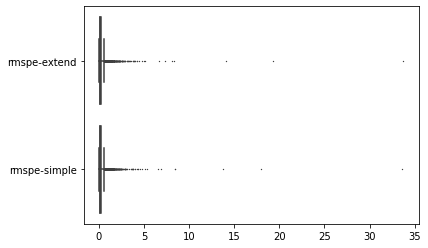

In [128]:
sns.boxplot(data=test[["rmspe-extend", "rmspe-simple"]], orient="h", fliersize=0.5)

<AxesSubplot:>

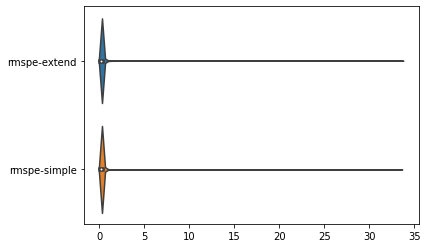

In [129]:
sns.violinplot(data=test[["rmspe-extend", "rmspe-simple"]], orient="h", fliersize=0.5)

<AxesSubplot:>

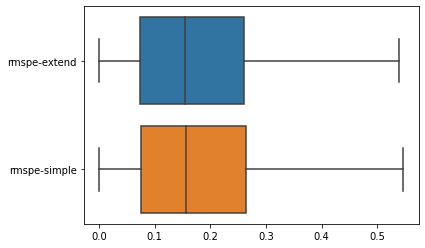

In [130]:
sns.boxplot(data=test[["rmspe-extend", "rmspe-simple"]], orient="h", showfliers=False)

### Write Predictions to CSV

In [131]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("extend2.csv", index=False)
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,rmspe-extend,rmspe-simple
0,0.001498,0.002010,169,0,0.002092,0.3420,0.3964
1,0.001420,0.001278,211,0,0.001247,0.1004,0.1217
2,0.003371,0.002403,266,0,0.002375,0.2871,0.2955
3,0.001155,0.001125,454,0,0.001220,0.0260,0.0567
4,0.001119,0.001298,627,0,0.001209,0.1596,0.0806
...,...,...,...,...,...,...,...
213292,0.002960,0.002569,32361,126,0.002653,0.1319,0.1037
213293,0.001725,0.001662,32614,126,0.001750,0.0365,0.0147
213294,0.012813,0.009830,32649,126,0.009512,0.2328,0.2576
213295,0.003511,0.004304,32724,126,0.004456,0.2258,0.2691


In [132]:
test = pd.read_csv("extend2.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,rmspe-extend,rmspe-simple
0,0.001498,0.002010,169,0,0.002092,0.3420,0.3964
1,0.001420,0.001278,211,0,0.001247,0.1004,0.1217
2,0.003371,0.002403,266,0,0.002375,0.2871,0.2955
3,0.001155,0.001125,454,0,0.001220,0.0260,0.0567
4,0.001119,0.001298,627,0,0.001209,0.1596,0.0806
...,...,...,...,...,...,...,...
213292,0.002960,0.002569,32361,126,0.002653,0.1319,0.1037
213293,0.001725,0.001662,32614,126,0.001750,0.0365,0.0147
213294,0.012813,0.009830,32649,126,0.009512,0.2328,0.2576
213295,0.003511,0.004304,32724,126,0.004456,0.2258,0.2691


## Model Feature Importance

In [133]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    sns.set(font_scale=1)

    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

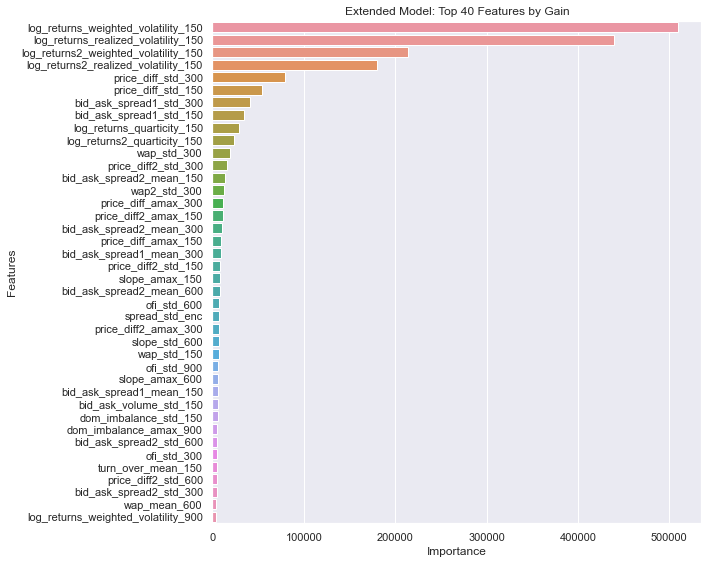

,Features,Importance
0,dispersion_amax_900,176.177867
1,wap_diff_std_600,209.306746
2,wap_diff_amax_900,230.828440
3,bid_ask_spread3_mean_600,248.492034
4,ask_diff_std_900,266.510360
...,...,...
230,price_diff_std_300,79594.879247
231,log_returns2_realized_volatility_150,180523.206620
232,log_returns2_weighted_volatility_150,214384.137029
233,log_returns_realized_volatility_150,439768.416648


In [140]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Extended Model: Top 40 Features by Gain', top=40,
               save_to_file="importance_by_gain_extend2.png")

mean_gain

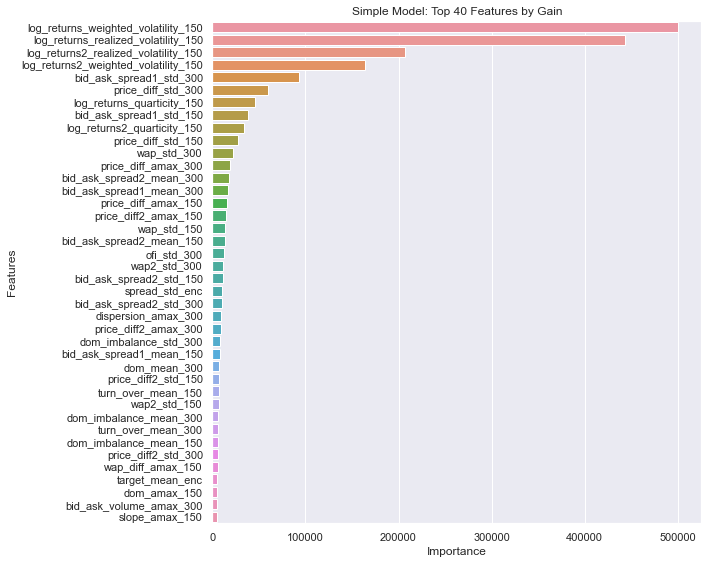

,Features,Importance
0,dispersion_mean_150,605.702885
1,bid_diff_std_150,657.733499
2,wap_diff_std_150,705.956189
3,ask_diff_std_150,744.486187
4,wap_diff_std_300,796.006064
...,...,...
118,bid_ask_spread1_std_300,92918.834403
119,log_returns2_weighted_volatility_150,164210.712033
120,log_returns2_realized_volatility_150,206717.338376
121,log_returns_realized_volatility_150,442978.645920


In [141]:
mean_gain = compute_mean_importance(gain_importance600)

plot_importance(mean_gain, title='Simple Model: Top 40 Features by Gain', top=40,
               save_to_file="importance_by_gain_simple.png")

mean_gain

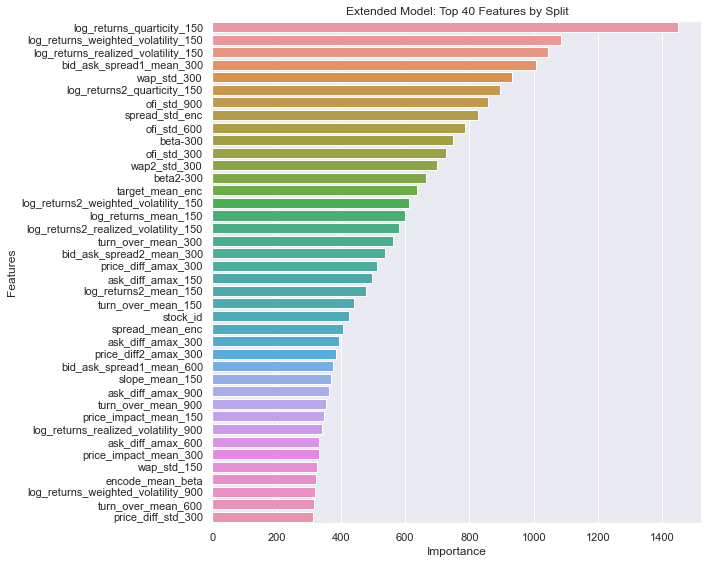

,Features,Importance
0,wap_diff_std_600,40.60
1,bid_diff_std_900,46.60
2,bid_ask_spread3_std_600,49.24
3,dispersion_amax_600,51.04
4,dispersion_amax_900,52.28
...,...,...
230,wap_std_300,931.76
231,bid_ask_spread1_mean_300,1006.84
232,log_returns_realized_volatility_150,1043.40
233,log_returns_weighted_volatility_150,1086.40


In [142]:
mean_split = compute_mean_importance(split_importance)
plot_importance(mean_split, title='Extended Model: Top 40 Features by Split', top=40,
               save_to_file="importance_by_split_extend2.png")

mean_split

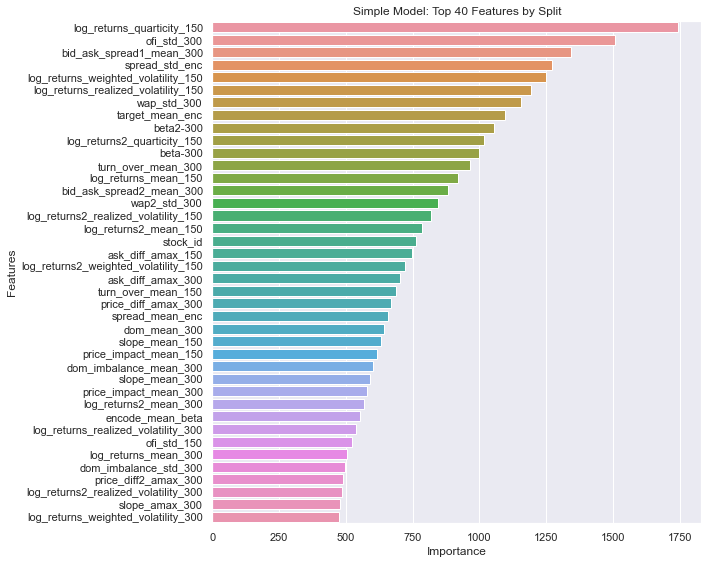

,Features,Importance
0,bid_ask_spread3_std_300,126.44
1,wap_diff_std_300,133.28
2,dispersion_amax_150,139.44
3,wap_diff_amax_300,145.56
4,wap_diff_amax_150,148.92
...,...,...
118,log_returns_weighted_volatility_150,1248.44
119,spread_std_enc,1271.28
120,bid_ask_spread1_mean_300,1341.32
121,ofi_std_300,1507.68


In [143]:
mean_split = compute_mean_importance(split_importance600)
plot_importance(mean_split, title='Simple Model: Top 40 Features by Split', top=40,
               save_to_file="importance_by_split_simple.png")

mean_split

<AxesSubplot:>

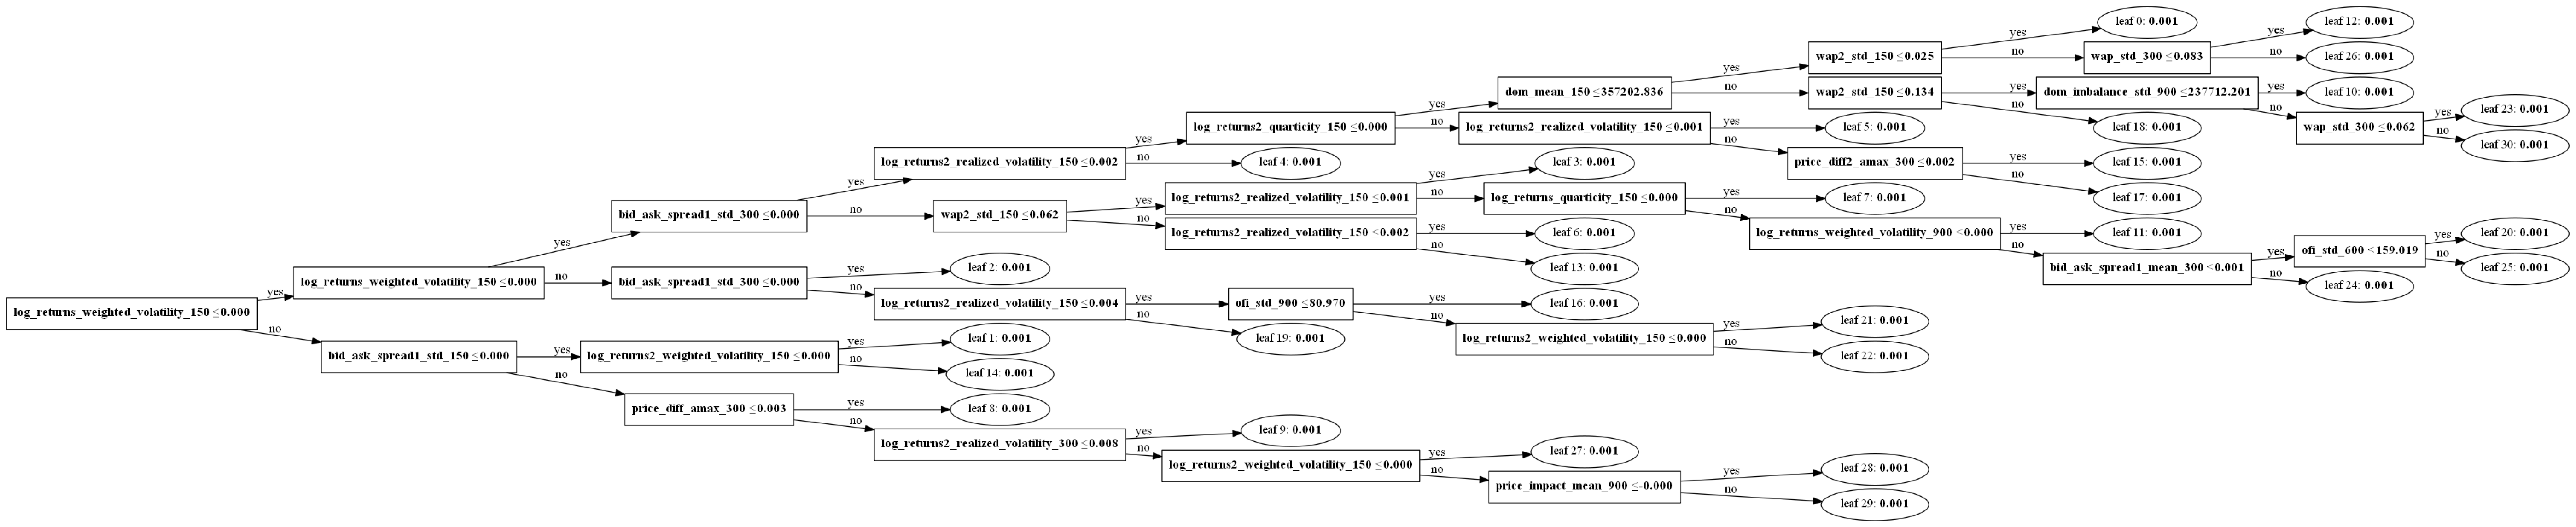

In [138]:
lgbm.plot_tree(models[0], tree_index = 0, figsize=(100,100))

<AxesSubplot:>

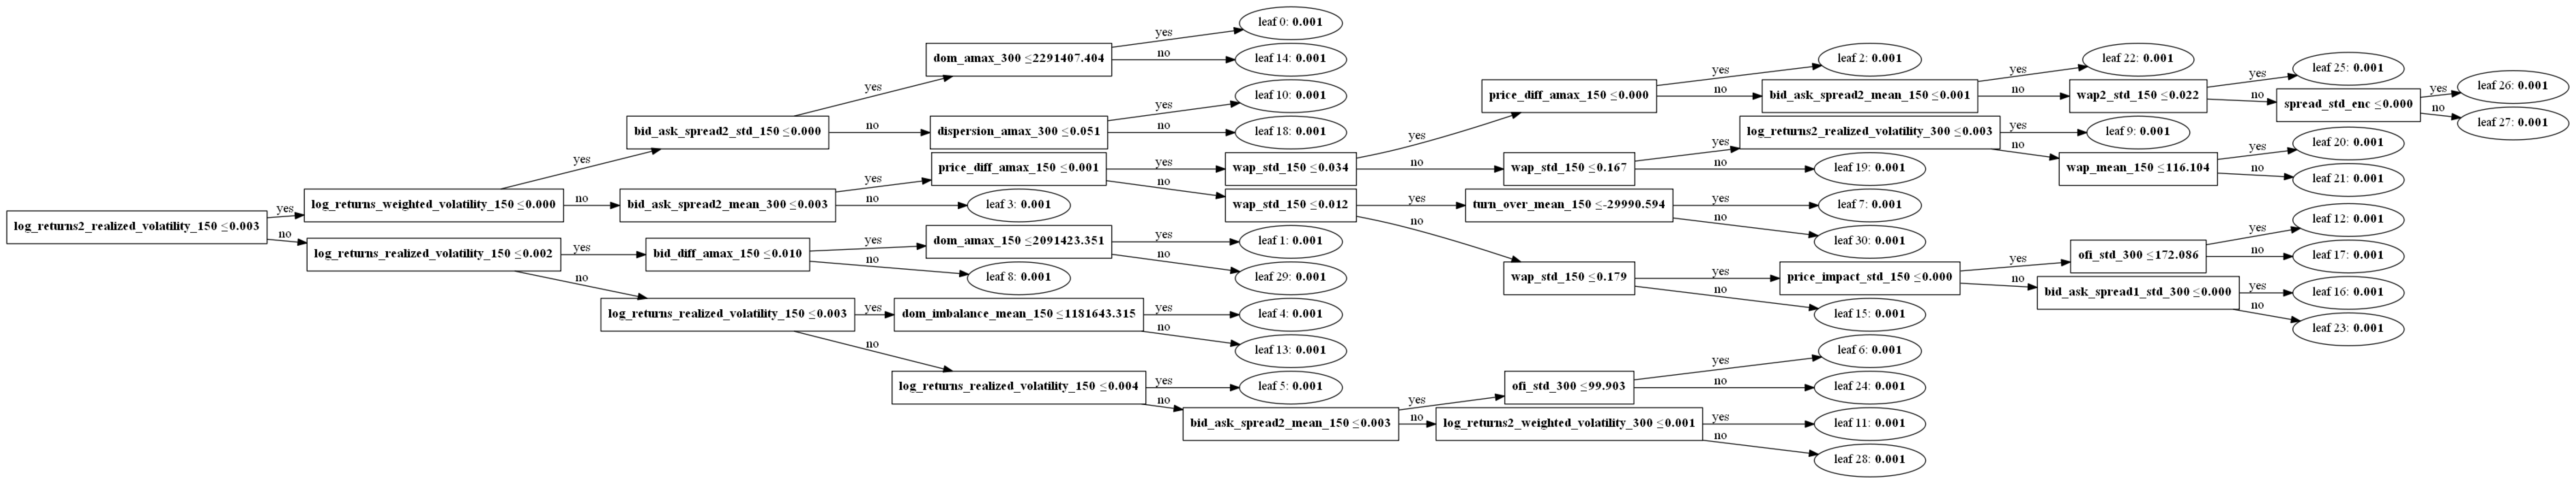

In [139]:
lgbm.plot_tree(models600[0], tree_index = 0, figsize=(100,100))

# T-Test

In [148]:
from scipy.stats import ttest_ind, ttest_rel

### Independent two sample t-test

In [146]:
ttest_ind(test['rmspe-extend'], test['rmspe-simple'])

Ttest_indResult(statistic=-3.8581884797016164, pvalue=0.00011424732926897064)

Since p-val < 0.05, we reject null hypothesis of t-test and conclude there is sufficient evidence the two models produce different rmspe scores.

### Welch’s t-Test
* Similar to independent two sample t-test except does not assume two populations amples came from have equal variance.

In [147]:
ttest_ind(test['rmspe-extend'], test['rmspe-simple'], equal_var=False)

Ttest_indResult(statistic=-3.858188479701617, pvalue=0.0001142473292713748)

Since p-val < 0.05, we reject null hypothesis of Welch’s t-test and conclude there is sufficient evidence to say the two models produce different rmspe scores.

### Paired Samples t-Test
* To determine if two population means are equal in which observations in one sample can be paired with observations in the other.
* E.g. if students studied one way to take a test, and then the same students studied another way to take the same test and results are different.

In [149]:
ttest_rel(test['rmspe-extend'], test['rmspe-simple'])

Ttest_relResult(statistic=-31.189195972360395, pvalue=4.521235912009054e-213)

Since p-val < 0.05, we reject null hypothesis of paired samples t-test and conclude there is sufficient evidence the two models produce different rmspe scores.